### Optimization: Utilizing Renewables and Energy Storage to Minimize Electricity Use


The adoption of renewable energy, particularly solar and wind technologies, has been steadily increasing. However, a significant challenge remains: the sun does not always shine, and the wind does not always blow. This variability means that the peak times for energy production often do not align with the times when customers need energy the most.

A viable solution to this problem is the use of batteries, which allow for the storage of energy that can be discharged and used at any time, regardless of production conditions.Here, we will explore the use of solar energy combined with battery storage to meet the energy demands of operating a university building and its associated courses. 

The information used for this example have been adopted from [IEEE's Predict+Optimize Technical Challenge](https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling).\
This Project is done as the involvement and assisstance Gurobi Optimization 101 training course (@ 2022 Gurobi Optimization, LLC)

### Problem Statement

Given a course schedule for the upcoming week and historical data about the solar potential, the objective is to determine the optimal battery charging and discharging schedule are in order to satisfy the energy demand for a building where the courses are held. The total energy demand is composed of the demand from the building itself plus the amount needed for each course. The example will look at two objectives:
- Minimize the total electricity purchased from the grid during the upcoming week
- Since electricity prices fluctuate, minimize the total cost of electricity purchased from the grid

At the same time, batteries have a finite capacity as well as limits on how much it can charge or discharge over a period of time. These impose constraints on the problem and make it difficult to solve.For simplicity, the time considered for each day will be limited to between 5am and 8pm.

### Solution Approach

The solution approach of the problem consists of two components: 1) **a forecasting component** for the solar availability and 2) **an optimization component** to determine the battery schedule as well as the amount of electricity purchased from the grid.

#### Solar Power Forecasting

The forecasting component was completed in the [energy_storage_ML](energy_storage_ML.ipynb) notebook in this folder. We'll use a given forecast from that model, as well as the demand of building and each of the courses to formulate and solve a mixed-integer programming (MIP) problem to find the optimal solution to the problem for each of the above objectives using gurobipy.

#### Optimal Battery Schedule
Now that we have a forecast of solar generation, we will create an optimization model that will schedule the charging and discharging of two batteries to help meet the building and course energy demand.

There are two batteries available that can be charged and discharged. Hence, we need an index to describe the existence and operation of each of the batteries. Finally, given that we would like to create the battery schedule in 30-minute intervals for the next month, we need to define an index for the time periods too. 

**Sets**

$B = \{\texttt{Battery0, Battery1}\}$

$T = \{0,1,...,179\}$ for the first Monday through Saturday of October, 2020

**Indices**

$b$: denotes the battery (0 or 1)

$t$: denotes the time periods (from 0 to 179) 

In [1]:
# Import packages and datasets 
%pip install gurobipy
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

batteries = ["Battery0", "Battery1"]
path = 'https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/Modeling_Session_2/'
solar_values_read = pd.read_csv(path+'pred_solar_values.csv')
time_periods = range(len(solar_values_read))

Note: you may need to restart the kernel to use updated packages.


### Input Parameters

Each of the batteries has a fixed capacity of how much energy it can store, as well as a maximum amount of energy that can be stored or discharged for each 30-minute period.

$c_{b}$: capacity of battery $b \in B \quad\quad \texttt{capacity[b]}$\
$p_{b}$: loss of energy (as a percentage) during transfer into battery $b\in B \quad\quad \texttt{p}\_\texttt{loss[b]}$\
$q_{b}$: quantity of initial energy in battery $b \in B \quad\quad \texttt{initial[b]}$\
$solar_{t}$: solar power generation of the panel for time period $t \in T \quad\quad \texttt{solar}\_\texttt{values[b]}$

In [4]:
capacity = {"Battery0": 60, "Battery1": 80} # in Kw
p_loss = {"Battery0": 0.95, "Battery1": 0.9} # proportion
initial = {"Battery0": 0, "Battery1": 0} # in kW
solar_values = round(solar_values_read.yhat,3)
solar_values.reset_index(drop = True, inplace = True)

The energy demand at a particular time period comes from two sources -- the building and the class -- and we are only concerned with the total demand.\
$d_{t}$: total building and class energy demand for time period $t\in T \quad\quad \texttt{total}\_\texttt{deamnd[t]}$

In [5]:
# Import the external datasets
schedule = pd.read_csv(path+'schedule_demand.csv')
avg_building = pd.read_csv(path+'building_demand.csv')
total_demand = schedule.sched_demand + avg_building.build_demand
print(f"Total Solar Generation: {solar_values.sum()} \nTotal Demand: {total_demand.sum()}")

Total Solar Generation: 4939.172 
Total Demand: 5250.6


#### Decision Variables

The decisions for this problem are 
- whether each battery is charged or discharged at a given time period
- how much to charge or discharge each battery
- the current state of the battery at a given time period
- as well as how much energy is purchased from the grid\
Let $f^{in}_{b,t}$ be the amount each battery, $b$, can `charges` at time period,  $t$, $\forall b\in B, t\in T$. $\quad\quad \texttt{flow}\_\texttt{in[b,t]}$\
Let $f^{out}_{b,t}$ be the amount each battery `discharges`, similarly. $\quad\quad \texttt{flow}\_\texttt{out[b,t]}$\
$grid_{t}$ : This variable indicates the amount of energy purchased from the grid at time period, $t$, $\forall t \in T$\
Set the max amount that each battery can charge or discharge in a single period to be 20 kW.

In [8]:
# Create a Gurobi Model
model = gp.Model() 

flow_in = model.addVars(batteries, time_periods, name="flow_in") 
flow_out = model.addVars(batteries, time_periods, name="flow_out")
grid = model.addVars(time_periods, name="grid")

The next two sets of decision variables will have a slightly different feel to them. We need to keep track of the amount of energy that is in each battery (i.e. its state) over each time period and we need to track of how much solar energy is used (by charging or directly supplying energy). 

$s_{b,t}$ is the current amount of energy in battery, $b$, at the end of time period, $t, \forall b\in B, t\in T$. $\quad\texttt{state[b,t]}$\
$gen_{t}$ is the amount of available solar energy that is used in period $t$, $\forall t \in T$. $\quad\texttt{gen[t]}$


In [9]:
state = model.addVars(batteries, time_periods, name="state") 
gen = model.addVars(time_periods, name="gen")

The last decision variables to add will take care of a tricky instance that can arise in a problem like this -- a battery cannot simultaneously charge and discharge. Thus, we need to make sure each battery, at each time period, will be doing one of three things: 1. **charge**, 2. **discharge**, or 3. **neither**. 

To model this we introduce a binary variable for each time period, $z_{b,t}, \forall b \in B, t \in T$, which we'll call $\texttt{zwitch}\_\texttt{[b,t]}$. Why *zwitch*? It's something I've done since my early optimization modeling days since a common single letter used for binary variables used like this in MO is $z$. This variable acts like switch -- hence, *zwitch*. 

In [11]:
zwitch = model.addVars(batteries, time_periods, vtype=GRB.BINARY, name="zwitch")

### Constraints
In each period, we need to make sure we meet energy demand. The available energy can come from three sources: 1) the grid, 2) solar panel, or 3) battery discharge. Additionally, we may decide to charge a battery which will help meet demand in a later period. 

$$
\begin{align*} 
\sum_b(f^{out}_{b,t}-p_bf^{in}_{b,t}) + gen_t + grid_t = d_t \quad \forall t \in T
\end{align*}
$$

In [12]:
model.addConstrs((gp.quicksum(flow_out[b,t] - p_loss[b]*flow_in[b,t] for b in batteries) + gen[t] + grid[t] == total_demand[t] 
                  for t in time_periods), name="power_balance")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

The state of each battery at a given time period affects the following state, along with the decision to charge or discharge each battery. So in general a battery's state at time $t$ is the state in the prior period and any charge or discharge. 

To do this, we set an initial state based on any initial energy each battery has, along with the first time period's charge/discharge decision. 

\begin{equation}
s_{b,0} = q_b + p_bf^{in}_{b,0} - f^{out}_{b,0}
\end{equation}

For each time period after (i.e. $t\ge1$), the state of a battery is found by:

\begin{equation}
s_{b,t} = s_{b,t-1} + p_bf^{in}_{b,t} - f^{out}_{b,t}, t \ge 1
\end{equation}


In [13]:
model.addConstrs((state[b,0] == initial[b] + p_loss[b]*flow_in[b,0] - flow_out[b,0] for b in batteries), name="initial_state")
model.addConstrs((state[b,t] == state[b,t-1] + p_loss[b]*flow_in[b,t] - flow_out[b,t] for b in batteries for t in time_periods if t >= 1), name="subsequent_states");

The availability of solar energy can be used in three places:
1. Battery0
2. Battery1
3. Directly to satisfy demand

Because of this we need to limit the amount the batteries can charge along with the amount used directly for demand. 

$$
\begin{equation}
f^{in}_{\texttt{Battery0},t} + f^{in}_{\texttt{Battery1},t} + gen_t \le solar_t, \quad \forall t \in T
\end{equation}
$$

In [14]:
model.addConstrs((flow_in['Battery0',t] + flow_in['Battery1',t] + gen[t] <= solar_values[t] for t in time_periods), name = "solar_avail");

### Binary Variables Modeling Logic
Using binary variables to model alternatives like what we have here is arguably the most difficult part of mathematical optimization modeling. It comes down to be able to represent a complex system using zeros, ones, and inequalities. To get the logic correct takes time and there is a lot of iteration at point to make sure it's done correctly. In short, do not worry if you find this part difficult. 

Let's formulate the constraints and then dive into why they work. 

$$
\begin{align*} 
f^{in}_{b,t} &\leq 20*z_{b,t} &\forall b \in B, t \in T \\
f^{out}_{b,t} &\leq 20*(1-z_{b,t}) &\forall b \in B, t \in T
\end{align*}
$$

To illustrate how this works let's consider an example -- suppose for one of batteries $f^{in}_{b,t} = 10$ in a time period. For the first inequality to hold it is *necessary* that $z_{b,t} = 1$, otherwise it is $0$ and $20*0 = 0$, which can't happen if $f^{in}_{b,t} = 10$. Then for the same time period, if $z_{b,t} = 1$, then  $1-z_{b,t} = 0$. This forces the right-hand side of the second inequality to be $0$ and this forces $f^{out}_{b,t} = 0$ making it impossible to discharge during this period. Similar logic applies if the battery *discharges* during a period (i.e. suppose $f^{out}_{b,t} = 10$).

With our `zwitch` being a binary variable, that means one of the two above cases will *always* happen for each time period. The important question -- is this a problem? The answer is no, and that's because we need to worry about what our inequalities *force* decision variables to be. Consider the case when $f^{in}_{b,t} = f^{in}_{b,t} = 0$, meaning a battery is neither charging nor discharging since the flow in and out is zero. This case won't violate either of the inequalities above and doesn't matter which value $z$ takes -- it can be $0$ or $1$ and the inequalities hold. 

This does raise an important point. If after solving this problem you were asked "How many periods did the battery charge and discharge?" It's easy to think that $z_{b,t} = 1$ means the battery is charging, so just add those up to get the number of charging periods. Then count the number of times if $z_{b,t} = 0$ to get the discharge count. This would be *incorrect* given what we saw when $f^{in}_{b,t} = f^{in}_{b,t} = 0$. 



In [15]:
model.addConstrs((flow_in[b,t] <= 20*zwitch[b,t] for b in batteries for t in time_periods), name = "to_charge")
model.addConstrs((flow_out[b,t] <= 20*(1-zwitch[b,t]) for b in batteries for t in time_periods), name = "or_not_to_charge");

Lastly, we need to set the max amount each battery can store, which means the battery's *state* must be bounded. These upper bounds can be set in the variable definition when using `addVars()`. Doing so there would require a list with the same dimensions as the decision variable. Below is another way to set the bound that quickly uses a `for` loop. 

In [16]:
for b, t in state:
    state[b,t].UB = capacity[b]

$$
\begin{align*} 
s_{b,t} \le c_b, \quad \forall b \in B
\end{align*}
$$

### Objective Function

The objective is to minimize the total amount of energy purchased from the grid over all time periods.

\begin{equation}
{\rm minimize} \quad \sum_{t} g_{t}
\end{equation}

In [17]:
model.setObjective(gp.quicksum(grid[t] for t in time_periods), GRB.MINIMIZE)

### Solving the Optimization Model and Output Analysis

In [18]:
model.optimize()
print(f"Total energy purchased from the grid: {round(model.objVal,3)} kWh")

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0xaa31bb6a
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
Found heuristic solution: objective 5250.6000000
Presolve removed 84 rows and 265 columns
Presolve time: 0.03s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Found heuristic solution: objective 4986.0960000
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 1.281678e+03, 582 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl

In [19]:
sol_in = pd.Series(model.getAttr('X',flow_in))
sol_out = pd.Series(model.getAttr('X',flow_out))
sol_level = pd.Series(model.getAttr('X',state))

print(f"Periods Battery0 charges: {sum(sol_in['Battery0'] > 0)}")
print(f"Periods Battery1 charges: {sum(sol_in['Battery1'] > 0)}")
print(f"Periods Battery0 discharges: {sum(sol_out['Battery0'] > 0)}")
print(f"Periods Battery1 discharges: {sum(sol_out['Battery1'] > 0)}")

Periods Battery0 charges: 49
Periods Battery1 charges: 26
Periods Battery0 discharges: 44
Periods Battery1 discharges: 21


Periods at Battery0 at Full Capacity: 30
Periods at Battery1 at Full Capacity: 14


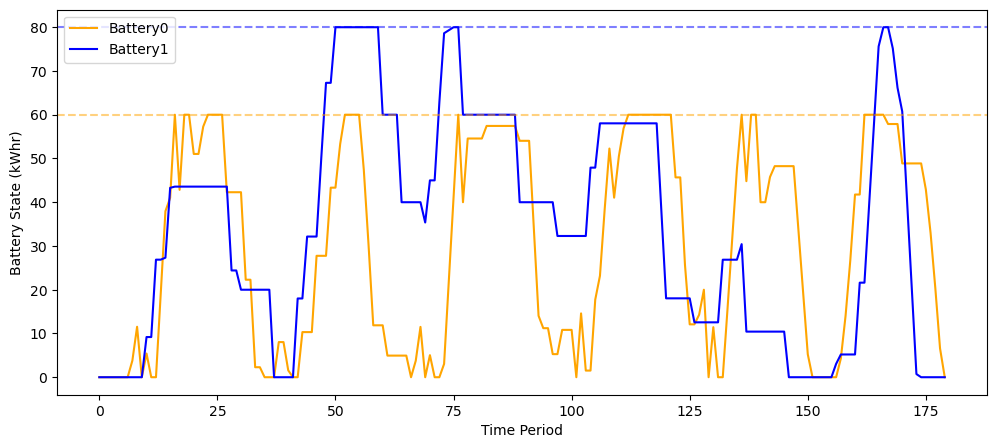

In [20]:
plt.figure(figsize=(12,5))
s0, = plt.plot(sol_level['Battery0'], c = 'orange')
s1, = plt.plot(sol_level['Battery1'], c = 'blue')
plt.ylabel('Battery State (kWhr)')
plt.xlabel('Time Period')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level['Battery1']==capacity['Battery1'])}");

How would changes to these values change the optimization?

Proportion of time periods where electrity is purchaced from the grid: 0.472


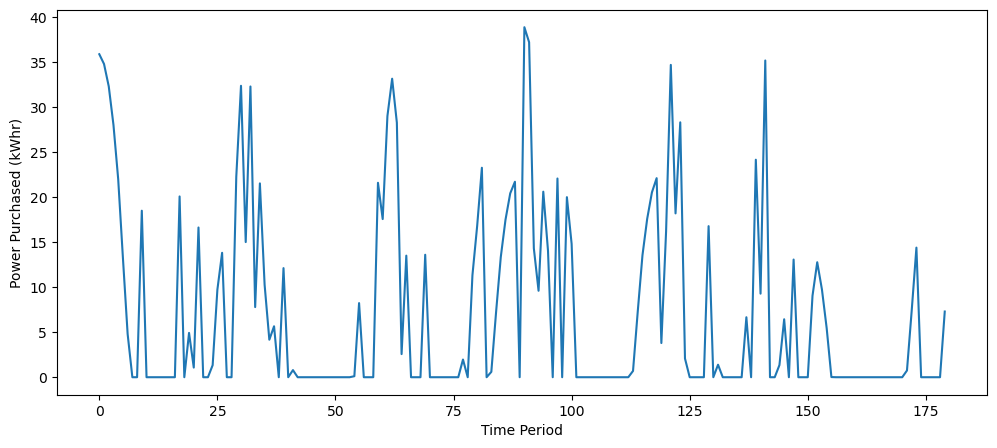

In [21]:
sol_grid = pd.Series(model.getAttr('X',grid))
plt.figure(figsize=(12,5))
plt.plot(sol_grid)
plt.ylabel('Power Purchased (kWhr)')
plt.xlabel('Time Period');
print(f"Proportion of time periods where electrity is purchaced from the grid: {round(sum(sol_grid > 0)/len(sol_grid),3)}")

Above, the number of periods where electricity was purchased from the grid was calculated. Is this the same as minimizing the total amount purchased? 
### Changing the Objective Function
we'll consider two objective functions with the second minimizing the cost of electricity purchaced. 

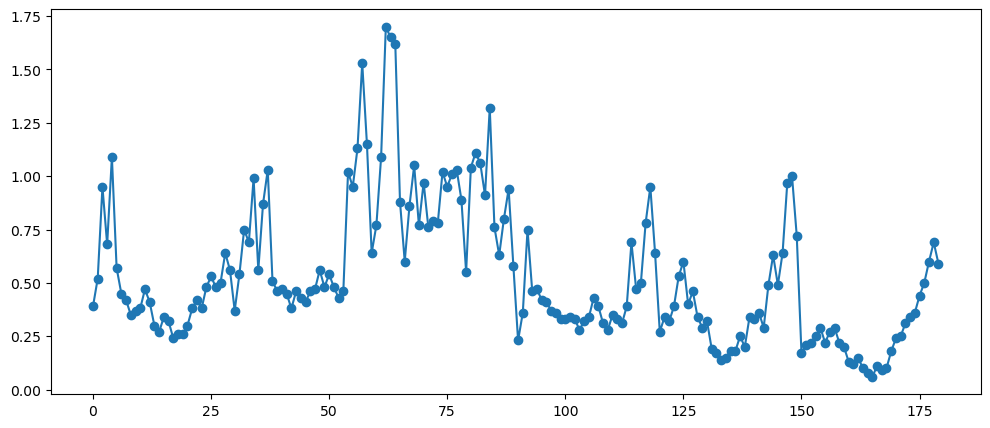

In [22]:
avg_price = pd.read_csv(path+'expected_price.csv')
# avg_price = pd.read_csv('expected_price.csv')
plt.figure(figsize=(12,5))
plt.plot(avg_price.index, avg_price.price, '-o');

In [24]:
model.setObjective(gp.quicksum(avg_price.price[time]*grid[time] for time in time_periods), GRB.MINIMIZE)

In [25]:
model.optimize() # run the optimization again
print(f"Energy cost for the week: ${round(model.objVal,2)}")

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x66bddde2
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

MIP start from previous solve produced solution with objective 617.569 (0.03s)
Loaded MIP start from previous solve with objective 617.569

Presolve removed 84 rows and 265 columns
Presolve time: 0.01s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 6.019761e+02, 754 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Ob

Periods at Battery0 at Full Capacity: 29
Periods at Battery1 at Full Capacity: 18


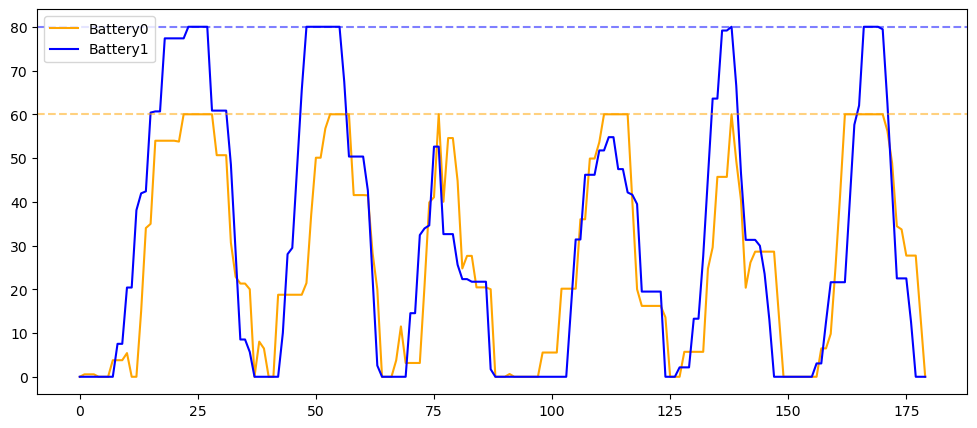

In [26]:
sol_level_cost = pd.Series(model.getAttr('X',state))
plt.figure(figsize=(12,5))
plt.plot(sol_level_cost['Battery0'], c ='orange')
plt.plot(sol_level_cost['Battery1'], c ='blue')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level_cost['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level_cost['Battery1']==capacity['Battery1'])}");

We see that each battery spends more time full or near-full, particuarly Battery0. This shows how adding cost will make batteries hold on to electricity to then be discharged during time periods where the cost is highest. 